In [1]:
import pandas as pd
import numpy as np
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import os

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_squared_error

import mlflow

In [2]:
os.chdir("/Users/sahelimukherjee/Documents/Personal/Learning/MLOps/projects/NYC_Ride_Duration_Prediction/Predicting-Ride-Duration/02-training")

In [3]:
tracking_uri = "sqlite:///mlflow.sqlite.db"

mlflow.set_tracking_uri(tracking_uri)
mlflow.set_experiment("nyc-taxi-duration-experiment-0527")



<Experiment: artifact_location='/Users/sahelimukherjee/Documents/Personal/Learning/MLOps/projects/NYC_Ride_Duration_Prediction/Predicting-Ride-Duration/02-training/mlruns/1', creation_time=1685199250624, experiment_id='1', last_update_time=1685199250624, lifecycle_stage='active', name='nyc-taxi-duration-experiment-0527', tags={}>

In [4]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
        df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [5]:
train_data_path = "/Users/sahelimukherjee/Documents/Personal/Learning/MLOps/projects/NYC_Ride_Duration_Prediction/Predicting-Ride-Duration/01-intro/data/train/green_tripdata_2021-01.parquet"
val_data_path = "/Users/sahelimukherjee/Documents/Personal/Learning/MLOps/projects/NYC_Ride_Duration_Prediction/Predicting-Ride-Duration/01-intro/data/val/green_tripdata_2021-02.parquet"

df_train = read_dataframe(train_data_path)
df_val = read_dataframe(val_data_path)

In [6]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [7]:
categorical = ['PU_DO'] #'PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [8]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [9]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

7.75871520559622

In [27]:
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [25]:
pwd

'/Users/sahelimukherjee/Documents/Personal/Learning/MLOps/projects/NYC_Ride_Duration_Prediction/Predicting-Ride-Duration/02-training'

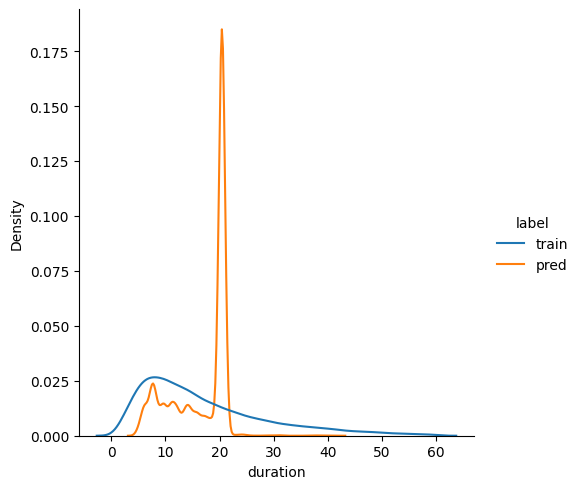

In [31]:
with mlflow.start_run():

    mlflow.set_tag("dev", "challenger")

    mlflow.log_param("train-data", train_data_path)
    mlflow.log_param("val-data", val_data_path)

    alpha = 0.003
    mlflow.log_param("alpha", alpha)

    lr = Lasso(alpha)
    lr.fit(X_train, y_train)

    y_pred = lr.predict(X_val)

    rmse = mean_squared_error(y_val, y_pred, squared=False)
    mlflow.log_metric("rmse", rmse)

    data = y_train.tolist() + y_pred.tolist()
    label = ['train']*(len(y_train)) + ['pred']*(len(y_pred))

    data = pd.DataFrame([data, label]).T
    data.columns = ['duration', 'label']

    fig = sns.displot(data, x= "duration", hue = 'label', kind="kde")

    mlflow.log_figure(fig.figure, "Train vs Pred.png")
    mlflow.log_artifact(local_path="models/lin_reg.bin", artifact_path= "models_pickle")

## Training XGBoost models

In [12]:
import xgboost as xgb

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials 
from hyperopt.pyll import scope

In [13]:
train = xgb.DMatrix(X_train, label=y_train)
val = xgb.DMatrix(X_val, label=y_val)

In [14]:
# objective function
def objective(params):
    with mlflow.start_run():
        mlflow.set_tag("model", "xgboost")
        mlflow.log_params(params)
        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=1000,
            evals=[(val, 'validation')],
            early_stopping_rounds=50
        )
        y_pred = booster.predict(val)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        mlflow.log_metric("rmse", rmse)

    return {'loss': rmse, 'status': STATUS_OK}


search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:linear',
    'seed': 42
}


best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=Trials()
)

[00:24:37] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:6.91612                           
[1]	validation-rmse:6.73040                           
[2]	validation-rmse:6.69803                           
[3]	validation-rmse:6.69005                           
[4]	validation-rmse:6.67911                           
[5]	validation-rmse:6.67427                           
[6]	validation-rmse:6.67161                           
[7]	validation-rmse:6.66972                           
[8]	validation-rmse:6.66784                           
[9]	validation-rmse:6.66664                           
[10]	validation-rmse:6.66490                          
[11]	validation-rmse:6.66445                          
[12]	validation-rmse:6.66404                          
[13]	validation-rmse:6.66505                          
[14]	validation

In [18]:
# best_params identified from least rmse 
best_params = {
                'learning_rate': 0.11442394011252557,
                'max_depth': 26,
                'min_child_weight': 1.7075412123012754,
                'objective': 'reg:linear',
                'reg_alpha': 0.11147277143990209,
                'reg_lambda': 0.01543183319645158,
                'seed': 42
            }

In [19]:
## training mlflow model with autologging
## https://mlflow.org/docs/latest/tracking.html#automatic-logging
## saves model artifacts including model, requirements and feat_imp
mlflow.xgboost.autolog()

booster = xgb.train(
                        params=best_params,
                        dtrain=train,
                        num_boost_round=1000,
                        evals=[(val, 'validation')],
                        early_stopping_rounds=50
                    )

## use auto-logged model to make predictions
## using python_func flavour
logged_model = "./mlruns/1/f1bfd6ee07c244968b224fff9df6f39f/artifacts/model"
loaded_model = mlflow.pyfunc.load_model(logged_model)

y_pred = loaded_model.predict(X_val)

2023/05/28 15:42:35 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'f1bfd6ee07c244968b224fff9df6f39f', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current xgboost workflow


[15:42:35] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:19.15662
[1]	validation-rmse:17.37797
[2]	validation-rmse:15.82681
[3]	validation-rmse:14.47715
[4]	validation-rmse:13.30797
[5]	validation-rmse:12.29664
[6]	validation-rmse:11.42506
[7]	validation-rmse:10.68039
[8]	validation-rmse:10.04344
[9]	validation-rmse:9.50053
[10]	validation-rmse:9.04061
[11]	validation-rmse:8.65105
[12]	validation-rmse:8.32155
[13]	validation-rmse:8.04542
[14]	validation-rmse:7.81345
[15]	validation-rmse:7.61747
[16]	validation-rmse:7.45299
[17]	validation-rmse:7.31473
[18]	validation-rmse:7.19857
[19]	validation-rmse:7.10043
[20]	validation-rmse:7.01734
[21]	validation-rmse:6.94519
[22]	validation-rmse:6.88536
[23]	validation-rmse:6.83393
[24]	validation-rmse:6.78929
[25]	validation-rmse:6.75205
[26]	validation-rmse:6.71994
[27

2023/05/28 15:44:02 WARNING mlflow.xgboost: Failed to infer model signature: could not sample data to infer model signature: please ensure that autologging is enabled before constructing the dataset.
2023/05/28 15:44:05 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/sahelimukherjee/Documents/Personal/Learning/MLOps/projects/venv/lib/python3.9/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils."


In [44]:
## without autologging
## saving model, dictvectorizer, requirements, etc.
mlflow.xgboost.autolog(disable= True) 
with mlflow.start_run():
    mlflow.set_tags({"model": "xgboost", "env": "dev", "developer": "Saheli"})
    mlflow.log_params(best_params)
    booster = xgb.train(
                params=best_params,
                dtrain=train,
                num_boost_round=1000,
                evals=[(val, 'validation')],
                early_stopping_rounds=50
            )
    
    y_pred = booster.predict(val)
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    mlflow.log_metric("rmse", rmse)

    mlflow.xgboost.log_model(booster, artifact_path= "mlflow_model")

    with open("models/preprocessor.b", "wb") as f:
        pickle.dump(dv, f)
    mlflow.log_artifact("models/preprocessor.b", artifact_path= "preprocessor")


## using logged model to make predictions
## using xgboost flavour
model_uri = "runs:/9e9a73877a704c3680d249a0234f7627/mlflow_model"
xgboost_model = mlflow.xgboost.load_model(model_uri)
y_pred = xgboost_model.predict(val)
print(y_pred[:10])

[17:32:11] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:19.15662
[1]	validation-rmse:17.37797
[2]	validation-rmse:15.82681
[3]	validation-rmse:14.47715
[4]	validation-rmse:13.30797
[5]	validation-rmse:12.29664
[6]	validation-rmse:11.42506
[7]	validation-rmse:10.68039
[8]	validation-rmse:10.04344
[9]	validation-rmse:9.50053
[10]	validation-rmse:9.04061
[11]	validation-rmse:8.65105
[12]	validation-rmse:8.32155
[13]	validation-rmse:8.04542
[14]	validation-rmse:7.81345
[15]	validation-rmse:7.61747
[16]	validation-rmse:7.45299
[17]	validation-rmse:7.31473
[18]	validation-rmse:7.19857
[19]	validation-rmse:7.10043
[20]	validation-rmse:7.01734
[21]	validation-rmse:6.94519
[22]	validation-rmse:6.88536
[23]	validation-rmse:6.83393
[24]	validation-rmse:6.78929
[25]	validation-rmse:6.75205
[26]	validation-rmse:6.71994
[27